In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy.linalg import inv
from numpy.random import randn
import random
from scipy import signal
from scipy.sparse import rand

random.seed(9999)
np.set_printoptions(precision=2)


In [4]:
def Jm2(par, x):
    y = (1+par/norm(x))*x
    return y

In [5]:
###linearity#####
def J2(INV, r, x):
    #r = INV*sigma*A.T * b
    y = INV @ x + r
#     print('inv:',INV.shape)
#     print('x',x.shape)
    return y

In [6]:
# L1 norm
def J1(par,x):
    return np.sign(x)*np.maximum(np.abs(x)-par,0) 


In [7]:
def J1(par,x):
    return np.maximum(np.abs(x)-par,0)*np.sign(x);


#L0 norm 
def J0(par,x):
    d = len(x)
    y = np.zeros(d)
    for i in range(d):
        y[i] = J0_1D(par,x[i])###
    return y

def J0_1D(par,x):
    if abs(x) > np.sqrt(2*par):
        out = x
    else:
        out = 0
    return out

In [8]:
y = J0(1, [-1,0, -2, 3,4,-0.5])

In [9]:
def l0_norm(x):
    count = []
    for i in x:
        if i !=0:
            count.append(i)
        else:pass
    return len(count)

def l1_norm(x):
    return norm(x, ord=1)

In [10]:
l0_norm([-1,0, -2, 3,4,-0.5])

5

In [11]:
##Generate the true signal
d, n = 100, 50
rs = 20
x_true = rand(d,1,0.1,random_state=rs)-2*rand(d,1,0.05,random_state=rs)
x_true = x_true.toarray()
x_true = np.cumsum(x_true,axis=0)
x_true = np.squeeze(np.asarray(x_true))
A = np.random.rand(n,d)

In [12]:
A.shape

(50, 100)

(100,)


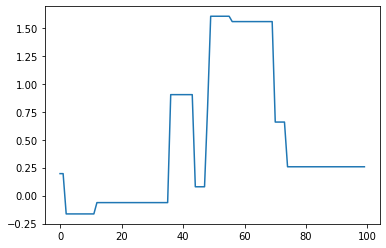

In [13]:
print(x_true.shape)
plt.plot(x_true)

In [14]:
####Linear operator##############
D = np.eye(d)- np.vstack((np.zeros((1,d)),np.hstack((np.eye(d-1),np.zeros((d-1,1))))))
# D = D[1:,:]

In [15]:
D

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [16]:
def CP_l1(x_true, D, A,maxit, t=0.1, l=1,rho=1, verbose=True):
    """Chambolle pock algorithm with l1-norm regularization
    t= primal stepsize
    l= regularization parameter
    rho = relaxation parameter
    x_true: input signal
    D: Sparse matrix
    A: recovering matrix
    s: dual stepsize
    """
    s=1/(t*norm(D)**2)
    
    num_sample, num_feat = D.shape
    b = A @ x_true

    INV=inv(np.eye(num_feat)+t*A.T @ A)

    r = t*INV @ A.T @ b
    
    x = np.random.rand(num_feat)
    y = np.random.rand(num_sample)
    
    objective = []
    errors = []
    corr = []
    res = []
    
    if verbose:
        print("Lauching CP 1-norm solver...")
        print(' | '.join([name.center(8) for name in ["it", "err", "obj"]]))
        
    for k in range(maxit):
        
        rho=1/np.log(k+2) 
        
        xold = np.copy(x)
        yold = np.copy(y)
        x = J2(INV,r, xold - t*D.T @ y)
        temp = (y+s*D @(2*x-xold))
        y = temp-s*J1(l/s,temp/s)
        
        x= xold+rho*(x-xold)
        y= yold+rho*(y-yold)
        
        error = norm(x_true - x)/ norm(x_true)
        co2D = np.corrcoef(x_true, x)
        co = co2D[0,1]
        ff = 1/2*norm(A @ x-b)**2+l*l1_norm(D @ x)
        errors.append(error)
        objective.append(ff)
        corr.append(co)
        res.append(norm(x-xold))
        

        if k%(maxit/10)==0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
#                                   ("%.2e" % y).rjust(8),
                              ("%.2e" % error).rjust(8),
                              ("%.2e" % ff).rjust(8)]))       
    return x, errors, corr, objective, res

In [17]:
def CP_l0(x_true, D, A,maxit, t=0.1, l=1,rho=1, verbose=True):
    """Chambolle pock algorithm l0-norm regularization    
    t= primal stepsize
    l= regularization parameter
    rho = relaxation parameter
    x_true: input signal
    D: Sparse matrix
    A: recovering matrix
    s: dual stepsize
    """
    s=1/(t*norm(D)**2)
    
    num_sample, num_feat = D.shape
    b = A @ x_true

    INV=inv(np.eye(num_feat)+t*A.T @ A)

    r = t*INV @ A.T @ b
    
    x = np.random.rand(num_feat)
    y = np.random.rand(num_sample)
    
    objective = []
    errors = []
    corr = []
    res = []
    
    if verbose:
        print("Lauching CP 0-norm solver...")
        print(' | '.join([name.center(8) for name in ["it", "err", "obj"]]))
        
    for k in range(maxit):
        
        rho=1/np.log(k+2) 
        
        xold = np.copy(x)
        yold = np.copy(y)
        x = J2(INV,r, xold - t*D.T @ y)
        temp = (y+s*D @(2*x-xold))
        y = temp-s*J0(l/s,temp/s)
        
        x= xold+rho*(x-xold)
        y= yold+rho*(y-yold)
        
        error = norm(x_true - x)/ norm(x_true)
        co2D = np.corrcoef(x_true, x)
        co = co2D[0,1]
        ff = 1/2*norm(A @ x-b)**2+l*l0_norm(D @ x)
        errors.append(error)
        objective.append(ff)
        corr.append(co)
        res.append(norm(x-xold))
        

        if k%(maxit/10)==0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
#                                   ("%.2e" % y).rjust(8),
                              ("%.2e" % error).rjust(8),
                              ("%.2e" % ff).rjust(8)]))       
    return x, errors, corr, objective, res



In [18]:
def PD_DRS_l0(x_true, D, A,maxit, t=0.1, l=1,rho=1,verbose=True):
    """Primal-Dual DRS with L0-norm regularization    
    t= primal stepsize
    l= regularization parameter
    rho = relaxation parameter
    x_true: input signal
    D: Sparse matrix
    A: recovering matrix
    s: dual stepsize
    """
    s=1/(t*norm(D)**2) 
    
    num_sample, num_feat = D.shape
    b = A @ x_true

    INV=inv(np.eye(num_feat)+t*A.T @ A)

    r = t*INV @ A.T @ b    
    a = np.hstack((np.eye(num_feat), t*D.T))
    c = np.hstack((-s*D , np.eye(num_sample)))
    Inversa=inv(np.vstack((a,c)))
    Fx_DR = []
    
    q = np.random.rand(num_sample)
    p = np.random.rand(num_feat) 
    
    objective = []
    objective1 = []
    errors = []
    corr = []
    res = []
    
    if verbose:
        print("Lauching DR 0-norm solver...")
        print(' | '.join([name.center(8) for name in ["iteration", "err", "obj"]]))      
    for k in range(maxit):
          
        rho=1/np.log(k+2) 
        
        pold = np.copy(p)
        
        x = J2(INV,r, p)

        z = q-s*J0(l/s,q/s)####
      
        m = np.resize(np.vstack((2*x-p, 2*z-q)),Inversa.shape[1])
        vect = Inversa@(m)
        u = vect[:num_feat]

        v = vect[num_feat:]

        p = p+rho*(u-x)
        q = q+rho*(v-z)
        qq = np.resize(q,x_true.shape)
        error = norm(x_true - p)/ norm(x_true)
        ff = 1/2*norm(A @ p-b)**2+l*l0_norm(D @ p) 
        
        co2D = np.corrcoef(x_true, x)
        co = co2D[0,1]
        corr.append(co)
        errors.append(error)
        objective.append(ff)
        res.append(norm(p-pold))
        
        if k%(maxit/10)==0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % error).rjust(8),
                              ("%.2e" % ff).rjust(8)])) 
            
    return x, errors, corr, objective, res


Lauching CP 0-norm solver...
   it    |   err    |   obj   
       0 | 6.75e-01 | 1.10e+02
    1000 | 7.98e-02 | 1.00e+02
    2000 | 6.24e-02 | 1.00e+02
    3000 | 4.73e-02 | 1.00e+02
    4000 | 4.99e-02 | 1.00e+02
    5000 | 4.81e-02 | 1.00e+02
    6000 | 4.87e-02 | 1.00e+02
    7000 | 4.76e-02 | 1.00e+02
    8000 | 4.97e-02 | 1.00e+02
    9000 | 4.93e-02 | 1.00e+02
Lauching DR 0-norm solver...
iteration |   err    |   obj   
       0 | 6.56e-01 | 1.52e+02
    1000 | 9.96e-02 | 1.00e+02
    2000 | 6.49e-02 | 1.00e+02
    3000 | 5.92e-02 | 1.00e+02
    4000 | 5.47e-02 | 1.00e+02
    5000 | 5.68e-02 | 1.00e+02
    6000 | 5.54e-02 | 1.00e+02
    7000 | 5.61e-02 | 1.00e+02
    8000 | 5.68e-02 | 1.00e+02
    9000 | 5.54e-02 | 1.00e+02


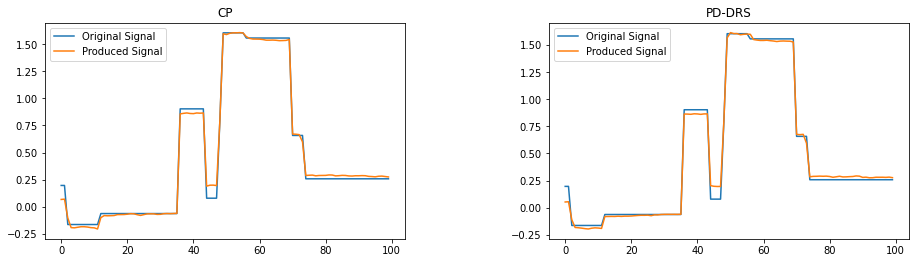

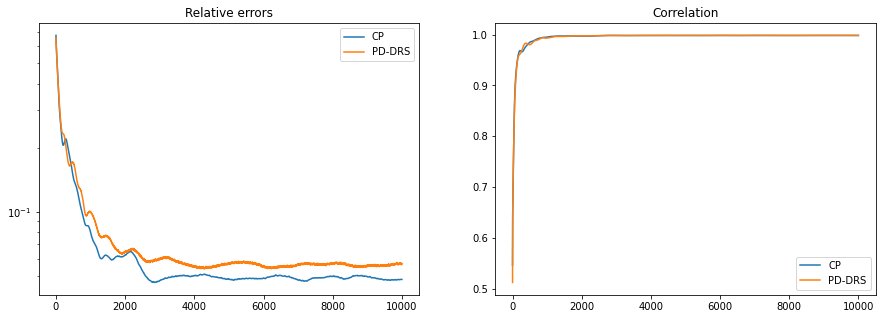

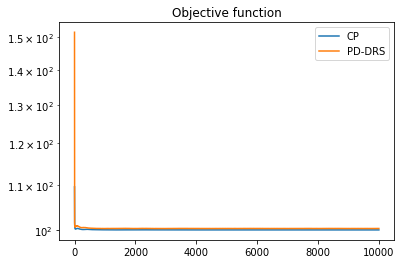

In [19]:
# solCP_1, errorsCP_1, corrCP_1, objectiveCP_1, resCP_1 = CP_l1(x_true, D, A, 10000, t=0.1, l=1 ,rho=1, verbose=True)
solCP_0, errorsCP_0, corrCP_0, objectiveCP_0, resCP_0 = CP_l0(x_true, D, A, 10000, t=0.1, l=1,rho=1, verbose=True)
solDR_0, errorsDR_0, corrDR_0, objectiveDR_0, resDR_0 = PD_DRS_l0(x_true, D, A,10000, t=0.1, l=1,rho=1,verbose=True)


fig, axs = plt.subplots(1,2, figsize=(15,5))
# axs[0,0].plot(x_true)
# axs[0,0].set_title('True signal')
# axs[0,1].plot(solCP_1)
# axs[0,1].set_title('CP for l1-norm')
axs[0].plot(x_true,label='Original Signal')
axs[0].plot(solCP_0,label='Produced Signal')
axs[0].set_title('CP')
axs[0].legend()
axs[1].plot(x_true,label='Original Signal')
axs[1].plot(solDR_0, label='Produced Signal')
axs[1].set_title('PD-DRS')
axs[1].legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.3, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

fig, axs = plt.subplots(1,2, figsize=(15,5))
# axs[0].semilogy(errorsCP_1,label='CP l1')
axs[0].semilogy(errorsCP_0,label='CP')
axs[0].semilogy(errorsDR_0,label='PD-DRS')
axs[0].legend()
axs[0].set_title('Relative errors')
# axs[1].plot(corrCP_1,label='CP l1')
axs[1].plot(corrCP_0,label='CP')
axs[1].plot(corrDR_0,label='PD-DRS')
axs[1].legend()
axs[1].set_title('Correlation')
plt.show()


plt.semilogy(objectiveCP_0,label='CP')
plt.semilogy(objectiveDR_0,label='PD-DRS')
plt.legend()
plt.title('Objective function')
plt.show()

t =  0.001


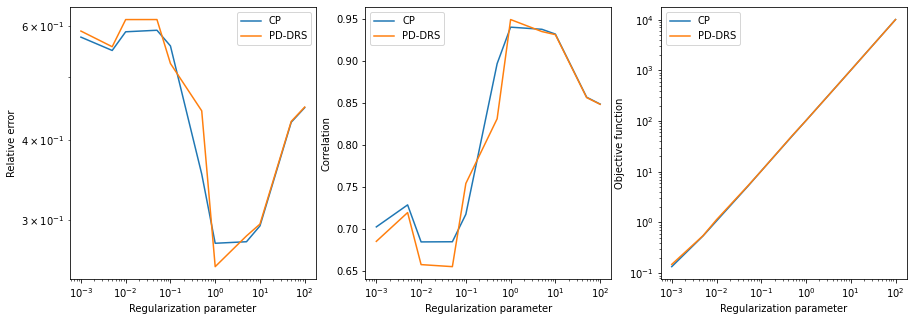

t =  0.01


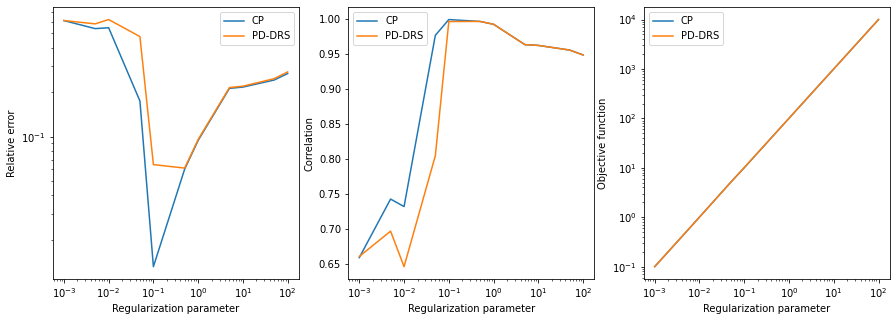

t =  0.1


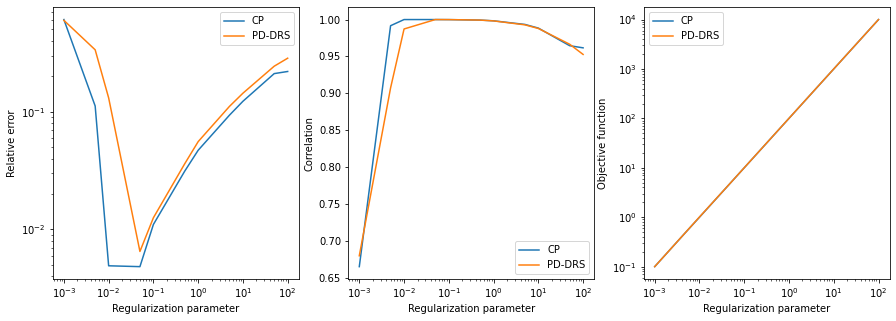

t =  1


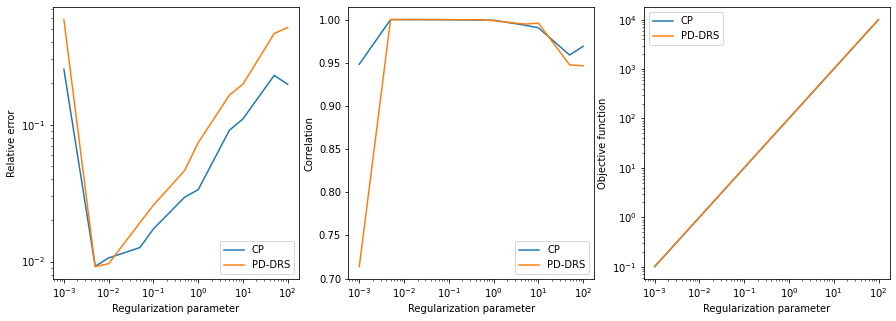

t =  2


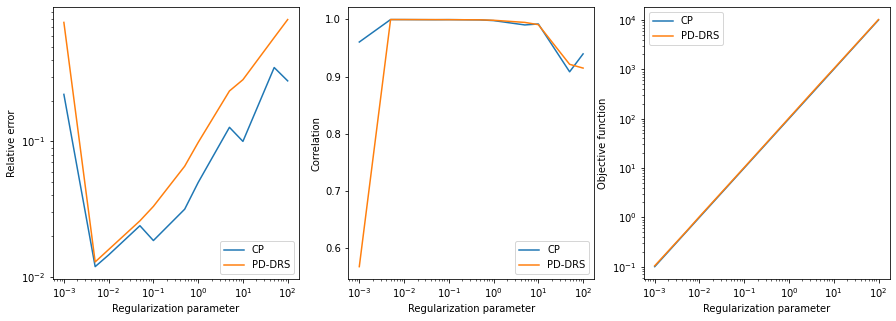

In [20]:
v_t = [0.001, 0.01, 0.1, 1, 2]
v_l = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

for t in v_t:
    
    eCP_1=[]; eCP_0=[]; eDR_0=[]; cCP_1=[]; cCP_0=[]; cDR_0=[];oCP_0=[];oDR_0=[]
    
    for l in v_l:
    
#         solCP_1, errorsCP_1, corrCP_1, objectiveCP_1, resCP_1 = CP_l1(x_true, D, A, 10000, t=t, l=l ,rho=1, verbose=False)
        solCP_0, errorsCP_0, corrCP_0, objectiveCP_0, resCP_0 = CP_l0(x_true, D, A, 10000, t=t, l=l ,rho=1, verbose=False)
        solDR_0, errorsDR_0, corrDR_0, objectiveDR_0, resDR_0 = PD_DRS_l0(x_true, D, A,10000, t=t, l=l ,rho=1,verbose=False)
        
#         eCP_1.append(errorsCP_1[-1])
        eCP_0.append(errorsCP_0[-1])
        eDR_0.append(errorsDR_0[-1])
#         cCP_1.append(corrCP_1[-1])
        cCP_0.append(corrCP_0[-1])
        cDR_0.append(corrDR_0[-1])
        oCP_0.append(objectiveCP_0[-1])
        oDR_0.append(objectiveDR_0[-1])          
        
    print('t = ', t)
    fig, axs = plt.subplots(1,3, figsize=(15,5))
#     axs[0].loglog(v_l,eCP_1,label='CP l1')
    axs[0].loglog(v_l,eCP_0,label='CP')
    axs[0].loglog(v_l,eDR_0,label='PD-DRS')
    axs[0].legend()
    axs[0].set_xlabel("Regularization parameter")
    axs[0].set_ylabel("Relative error")
#     axs[1].semilogx(v_l,cCP_1,label='CP l1')
    axs[1].semilogx(v_l,cCP_0,label='CP')
    axs[1].semilogx(v_l,cDR_0,label='PD-DRS')
    axs[1].legend()
    axs[1].set_xlabel("Regularization parameter")
    axs[1].set_ylabel("Correlation")    
    axs[2].loglog(v_l,oCP_0,label='CP')
    axs[2].loglog(v_l,oDR_0,label='PD-DRS')
    axs[2].legend()
    axs[2].set_xlabel("Regularization parameter")
    axs[2].set_ylabel("Objective function")
    plt.show()
